# ESRGAN SuperResolution 
Implementation of scaling with Metrics score Testing.

Sources:</br>
https://www.tensorflow.org/hub/tutorials/image_enhancing

In [1]:
# Libraries
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [2]:
# Constants and model
# Declaring Constants
IMAGE_PATH = "original_own.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [3]:
# Helper
def preprocess_image(image_path):
    """ Loads image from path and preprocesses to make it model ready
        Args:
          image_path: Path to the image file
    """
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # If PNG, remove the alpha channel. The model only supports
    # images with 3 color channels.
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[..., :-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(
        hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)


def save_image(image, filename):
    """
      Saves unscaled Tensor Images.
      Args:
        image: 3D image tensor. [height, width, channels]
        filename: Name of the file to save.
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("Saved as %s.jpg" % filename)


%matplotlib inline


def plot_image(image, title=""):
    """
      Plots images from image tensors.
      Args:
        image: 3D image tensor. [height, width, channels].
        title: Title to display in the plot.
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)


def plot_multi(orig, scaled):
    # Compare
    plt.rcParams['figure.figsize'] = [20, 15]
    fig, axes = plt.subplots(1, 2)
    fig.tight_layout()

    plt.subplot(121)
    plot_image(tf.squeeze(orig), title="Original")

    plt.subplot(122)
    fig.tight_layout()
    plot_image(tf.squeeze(scaled), "Super Resolution")
    return 0


def downscale_image(image):
    """
        Scales down images using bicubic downsampling.
        Args:
            image: 3D or 4D tensor of preprocessed image
    """
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(
        tf.cast(
            tf.clip_by_value(image, 0, 255), tf.uint8))

    lr_image = np.asarray(
        Image.fromarray(image.numpy())
        .resize([image_size[0] // 4, image_size[1] // 4],
                Image.BICUBIC))

    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image


def superscale(image):
    # Load Model
    model = hub.load(SAVED_MODEL_PATH)

    # process
    start = time.time()
    processed_image = model(image)
    tf.squeeze(processed_image)
    print("Time Taken: %f" % (time.time() - start))
    return tf.squeeze(processed_image)


Time Taken: 4.832064


0

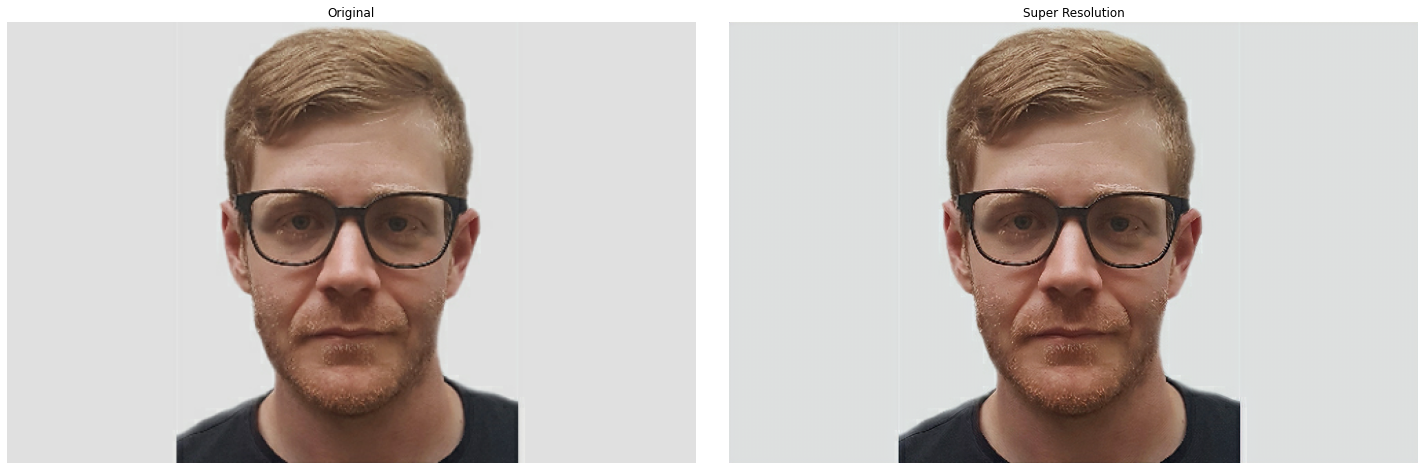

In [4]:
# Processing
orig_image = preprocess_image(IMAGE_PATH)
ss_image = superscale(orig_image)

plot_multi(orig_image,ss_image)
#save_image(tf.squeeze(ss_image), filename="SS_Image")